## Notebook to solve 1D elliptic, self adjoint eigenvalue problem

Here we solve a (formally) self adjoint, regular elliptic problem in 1D, the problem is of the form:

$$ \frac{d}{dx}(p(x)\frac{d}{dx}u) + q(x) u(x) = \lambda r(x) u(x)$$

with $g(x) > 0$. We solve it in an interval $[0,L]$ and use boundary conditions $\{u_0, u_1\}$ at the left-right boundaries. 

In [1]:
from dolfin import *

if not has_linear_algebra_backend("PETSc"):
    print("DOLFIN has not been configured with PETSc. Exiting.")
    exit()
if not has_slepc():
    print("DOLFIN has not been configured with SLEPc. Exiting.")
    exit()

In [2]:
from mshr import *
from math import pi, log
#import math 


import numpy as np
import matplotlib.pyplot as mpl

We define several instances:

#### Test 1 is just the second derivatives (p=1, q=0, r=1)
The solutions are $u_n = sin(n*x)$ in the interval $[0,\pi]$, and the eigenvalues are $\lambda_n = n^2$.

#### Test 2 has (p=x, q=0, r=1/x)
The solutions are: $(\lambda = (\frac{n\pi}{\ln 2})^2\;\;\;\; n>0, u_n = \sin(\frac{n\pi}{\ln 2}\ln x)$, in the interval $[1,2]$.

#### Test 3 the harmonic oscillator (p=1, q=x^2, r=1)
The solutions are: $(\lambda = n, \;\;\; n\geq 0, u_n = e^{-x^2/2}H_n)$, where $H_n$ are the Hermite polynomials.


In [3]:
#test_1 = True
test_1 = False 
#test_2 = True 
test_2 = False
test_3 = False 
#test_3 = True 

Define an equi-spaced grid with N nodes of length L

In [4]:
# Create mesh with N point

if test_1:
    X0 = 0.
    X1 = 1*pi # using length pi for simplicity in the test
    N=200
elif test_2:
    X0 = 1.
    X1 = 2.
    N = 200
elif test_3:
    X0 = -10.
    X1 = 10.
    N = 2000
else: 
    X0=0
    X1=20
    N=1000
    
mesh = IntervalMesh(N, X0, X1)
#plot(mesh)

Since we shall be solving it with finite elements we first define the fuction space for these elements:

In [5]:
V = FunctionSpace(mesh, "CG", 2)

We asign boundary values and define the boundaries where we apply them. We can also do Neumann BC.

In [6]:
#if test_4:
#    u0 = Constant(1) # boundary values set to one
#    u1 = Constant(1)
#else:
#    u0 = Constant(0) # boundary values set to zero
#    u1 = Constant(0)

u0 = Constant(-1) # boundary values set to one
u1 = Constant(1)

def DirichletBoundary_0(x, on_boundary):
    tol = 1e-14
    return on_boundary and abs(x[0]-X0) < tol

def DirichletBoundary_1(x, on_boundary):
    tol = 1e-14
    return on_boundary and abs(x[0]-X1) < tol

bc_0 = DirichletBC(V, u0, DirichletBoundary_0)
bc_1 = DirichletBC(V, u1, DirichletBoundary_1)

bcs = [bc_0, bc_1]

We define the two free fuctions, $g$ and $pot$. To test the code we have the case tests, for which the fuctions are simple and we know the solution explicitly. 

In [7]:

if test_1: 
    p = Constant(1)
    q = Constant(0)
    r = Constant(1)
elif test_2:
    p = Expression('x[0]', degree=2)
    q = Constant(0)
    r = Expression('1/x[0]', degree=1)
elif test_3:
    p = Constant(1)
    q = Expression('x[0]*x[0]',degree=1)
    r = Constant(1)
else:
    p = Expression('(1 + x[0] + 0.5*x[0]*x[0])/(10 + 0.5*x[0]*x[0])', degree=2)
    q = Expression('-10*x[0]/(1 + 5*x[0]*x[0])', degree=1)
    r = Constant(1)

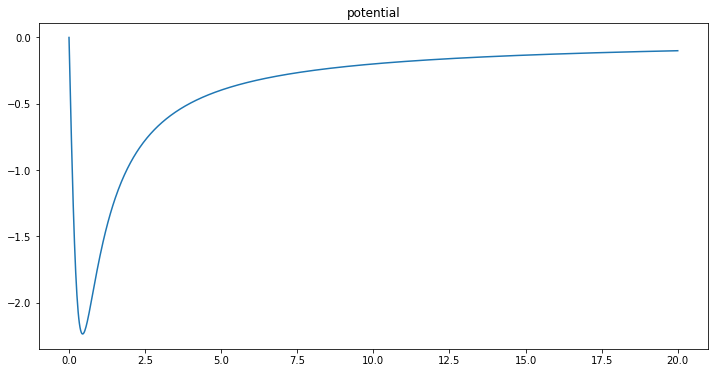

In [8]:
q_n = Function(V)
q_n = project(q,V)
fig = mpl.figure(figsize=(12,6))
plot(q_n, title="potential")

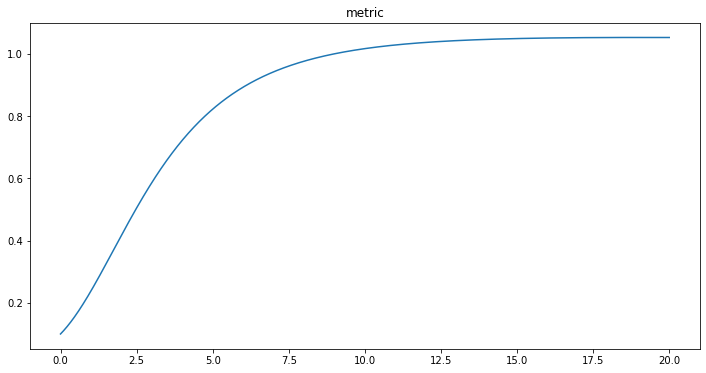

In [9]:
p_n = Function(V)
p_n = project(p,V)
fig = mpl.figure(figsize=(12,6))
plot(p_n, title="metric")

Now we define the variational problem

In [10]:
u = TrialFunction(V)
v = TestFunction(V)

a = p*inner(grad(u), grad(v))*dx
b = q*inner(u,v)*dx
c = r*inner(u,v)*dx

Here we introduce the solver and its parámeters, and the solve the system.

In [11]:
# Assemble into PETSc matrices
#dummy = v[0]*dx
dummy = v*dx
A = PETScMatrix()
B = PETScMatrix()
l = PETScVector()

assemble_system(a+b, dummy, bcs, A_tensor=A, b_tensor=l)
#assemble_system(a, dummy, bcs, A_tensor=A)
#[bc.zero(A) for bc in bcs]
assemble_system(c, dummy, bcs, A_tensor=B, b_tensor=l)
#assemble_system(c, dummy, bcs, A_tensor=B)
#[bc.zero(B) for bc in bcs]

#E = SLEPc.PEP().create()
#E.setOperators([A.mat(), B.mat(), A.mat()]) 

#solve now around
point = 2.
eigensolver = SLEPcEigenSolver(A, B)
eigensolver.parameters["solver"] = "krylov-schur"
eigensolver.parameters["problem_type"] = "gen_hermitian"
    #
eigensolver.parameters["spectrum"] = "target magnitude"
eigensolver.parameters["spectral_transform"] = "shift-and-invert"
eigensolver.parameters["spectral_shift"] = point
eigensolver.parameters["tolerance"] = 1.e-4 # 1.e-14
eigensolver.parameters["maximum_iterations"] = 100

PETScOptions.set("eps_view")

#eigensolver.parameters["spectrum"] = 'smallest real'
neigs = 12
eigensolver.solve(neigs)
print(eigensolver.get_number_converged())

Calling FFC just-in-time (JIT) compiler, this may take some time.
18


In [13]:
computed_eigenvalues = []
positive_computed_eigenvalues = []
negative_computed_eigenvalues = []

for i in range(min(neigs, eigensolver.get_number_converged())):
    r, _ = eigensolver.get_eigenvalue(i) # ignore the imaginary part
    
    if test_1 or test_2 or test_3:
        if r>0.00001: # ignore zero eigenvalues
            positive_computed_eigenvalues.append(r)
    else:
        if r<0.0000: # ignore positive eigenvalues        
            negative_computed_eigenvalues.append(r)
            
    computed_eigenvalues.append(r)
    
num_eig = np.sort(np.array(computed_eigenvalues))
length = len(num_eig)

if test_1 or test_2 or test_3:
    pos_num_eig = np.sort(np.array(positive_computed_eigenvalues))
    length_p = len(pos_num_eig)
else:
    neg_num_eig = np.sort(np.array(negative_computed_eigenvalues))
    length_n = len(neg_num_eig)

np.set_printoptions(formatter={'float': '{:5.5f}'.format})
if test_1 or test_2 or test_3:
    print("Numerical eigenvalues:  {}".format(pos_num_eig))
else:
    print("Numerical eigenvalues:  {}".format(num_eig))
    print("Unsorted: {}".format(np.array(computed_eigenvalues)))

Numerical eigenvalues:  [0.04145 0.22158 0.44702 0.71480 1.00000 1.02322 1.37123 1.75815 2.18349
 2.64691 3.14820 3.68718]
Unsorted: [2.18349 1.75815 1.37123 2.64691 1.02322 1.00000 3.14820 0.71480 0.44702
 3.68718 0.22158 0.04145]


In [14]:
if test_1:
    true_eig = np.sort(np.array([float((m+1)**2)\
        for m in range(length_p)]))#[1:length+1]
    print("Exact eigenvalues:  {}".format(true_eig))
elif test_2:
    true_eig = np.sort(np.array([float(((pi*(m+1))/ln(2))**2)\
        for m in range(length_p)]))#[1:length+1]
    print("Exact eigenvalues:  {}".format(true_eig))
elif test_3:
    true_eig = np.sort(np.array([float(2*m+1)\
        for m in range(length_p)]))#[1:length+1]
    print("Exact eigenvalues:  {}".format(true_eig))

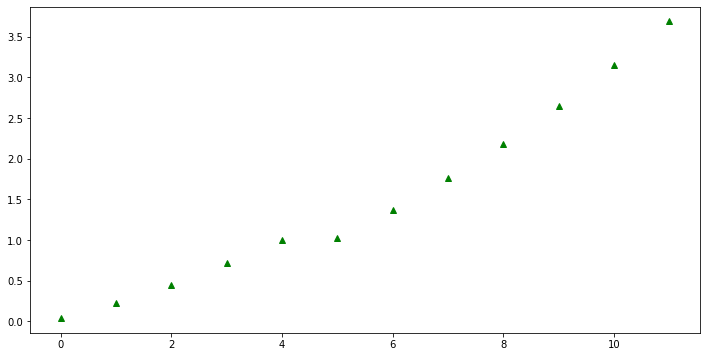

In [15]:
mpl.figure(figsize=(12,6)) 
if test_1 or test_2 or test_3:
    x = np.arange(length_p)
    mpl.plot(x,pos_num_eig[:length_p],'g^',x,true_eig[:length_p],'r.')
else:
    x = np.arange(length)
    mpl.plot(x,num_eig[:length],'g^')
    #x = np.arange(length_n)
    #mpl.plot(x,neg_num_eig[:length_n],'g^')

Here we can extract the eigenvectos and plot them. Notice that there is a real and imaginary part! We normalize them with the L2 norm. 

In [16]:
r, c, rx, cx = eigensolver.get_eigenpair(2) 
# for tests_1 and 2 use n=10 for test_3 use 3
print('The eigenvalue is: %2.5f'%r)

# save for plotting

u = Function(V)
u.vector()[:] = rx


# Re-scale solution to have L2 norm unity.
u_n = Function(V)

square = inner(u,u)*dx
L2_inv = 1./sqrt(assemble(square))

u_n = project(L2_inv*u,V)
    
square = inner(u_n,u_n)*dx
print("This should be unit = %2.2f"%assemble(square))


The eigenvalue is: 1.37123
This should be unit = 1.00


And here we plot them:

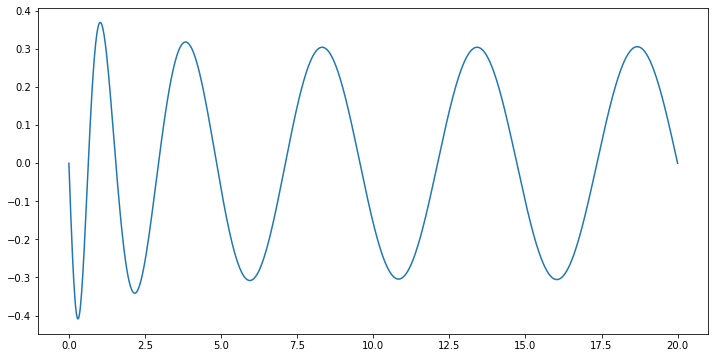

In [17]:
# Plot eigenfunction and mesh
fig = mpl.figure(figsize=(12,6))
#modulo = plot(inner(u_n,u_n))
plot(u_n)
#plot(mesh)
#fig.colorbar(modulo, shrink=0.5, aspect=5)

And here we can save them into a file to see it with visit, for instance. 

In [18]:
# Save solution to file in VTK format

vtkfile_u = File('Eigenvectors/u.pvd.gz')
vtkfile_u << u_n    

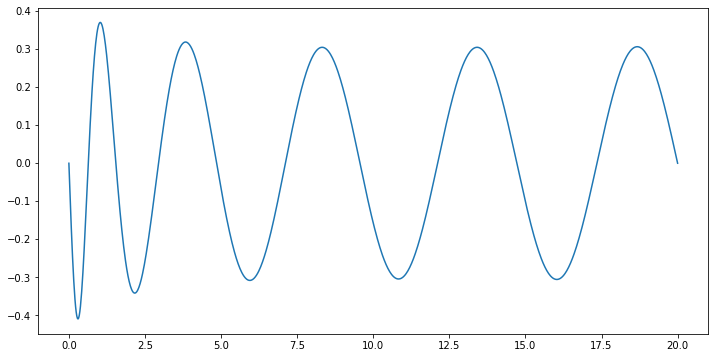

In [19]:
e_n = Function(V)
ep_n = Function(V)
ep_nn = Function(V)

#square = inner(u,u)*dx
#L2_inv = 1./sqrt(assemble(square))

#u_n = project(L2_inv*u,V)

if test_1: 
    e_n = Expression("factor*sin(n*x[0])", \
          factor=Constant(-sqrt(2/pi)), n=Constant(11.), degree=4)
if test_2: 
    e_n = Expression("factor*sin(freq*std::log(x[0])/std::log(2.))", \
          factor=Constant(1), freq=Constant(11.*pi), degree=4)
    ep_n = project(e_n,V)
    L2 = inner(ep_n,ep_n)*dx
    L2_inv = 1./sqrt(assemble(L2))
    ep_nn = project(L2_inv*ep_n,V)
    print(assemble(inner(ep_nn,ep_nn)*dx))
    
if test_3: 
    e_n = Expression("factor*exp(-x[0]*x[0]/2)*(8*x[0]*x[0]*x[0]-12*x[0])", \
          factor=Constant(1), degree=4)
    ep_n = project(e_n,V)
    L2 = inner(ep_n,ep_n)*dx
    L2_inv = 1./sqrt(assemble(L2))
    ep_nn = project(L2_inv*ep_n,V)
    print(assemble(inner(ep_nn,ep_nn)*dx))
    
fig = mpl.figure(figsize=(12,6))
plot(u_n + ep_nn) # Warning this can be + or - depending of a phase.
        

In [20]:
sqrt(2/pi)

0.7978845608028654